# IMPORTS
This cell imports the essential libraries required for building, training, and evaluating the image colorization model. These libraries provide the tools and functionality to work with deep learning models, datasets, and data transformations.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# GPU CHECKS
This cell checks the availability of a CUDA-enabled GPU and sets the appropriate device for PyTorch computations. If a GPU is available, it retrieves and prints detailed information about the GPU. Otherwise, it defaults to the CPU and notifies the user.

In [2]:
# Check if a CUDA-enabled GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    # If a GPU is available, display its details
    print(f"Current CUDA device index: {torch.cuda.current_device()}")  # Current active device index
    print(f"CUDA device object: {torch.cuda.device(0)}")  # Device object for the first GPU
    print(f"Number of available CUDA devices: {torch.cuda.device_count()}")  # Total number of GPUs available
    print(f"CUDA device name: {torch.cuda.get_device_name(0)}")  # Name of the first GPU
else:
    # If no GPU is available, notify the user that the CPU will be used
    print("No NVIDIA GPU detected. Using CPU instead.")


No NVIDIA GPU detected. Using CPU instead.


# IMPORT DATASETS 
This cell prepares the CIFAR-10 dataset for training and testing by applying transformations and creating DataLoaders for efficient batch processing.

In [3]:

# Define the data transformation pipeline
# - Converts images to PyTorch tensors (normalization can be added here if needed)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL images or NumPy arrays to PyTorch tensors
])

# Load the CIFAR-10 training dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data',        # Directory to store/download the dataset
    train=True,           # Specify that we want the training split
    download=True,        # Download the dataset if it's not already available
    transform=transform   # Apply the defined transformations
)

# Create a DataLoader for the training dataset
train_loader = torch.utils.data.DataLoader(
    train_dataset,        # Dataset to load
    batch_size=64,        # Number of samples per batch
    shuffle=True,         # Shuffle the dataset at every epoch for better generalization
    num_workers=2         # Number of subprocesses for data loading
)

# Load the CIFAR-10 test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='./data',        # Same directory as the training dataset
    train=False,          # Specify that we want the test split
    download=True,        # Download the dataset if it's not already available
    transform=transform   # Apply the same transformations as for training
)

# Create a DataLoader for the test dataset
test_loader = torch.utils.data.DataLoader(
    test_dataset,         # Dataset to load
    batch_size=64,        # Number of samples per batch
    shuffle=False,        # Do not shuffle; order is preserved for evaluation
    num_workers=2         # Number of subprocesses for data loading
)

100%|██████████| 170498071/170498071 [00:17<00:00, 9898947.03it/s] 


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# DEFINES MODEL
This code defines a Convolutional Neural Network (CNN) called ColorizationNet, specifically designed for image colorization tasks. The model processes grayscale 
images and predicts the corresponding color channels (RGB) for each pixel.

In [17]:
# Define the colorization model
class ColorizationNet(nn.Module):
    """
    A convolutional neural network (CNN) designed for image colorization.
    The model takes a grayscale image as input and predicts the chrominance 
    channels (color information) for each pixel.
    """
    def __init__(self):
        """
        Initializes the ColorizationNet model by defining its layers.
        """
        super(ColorizationNet, self).__init__()
        
        # First convolutional layer
        # Input: 1 channel (grayscale), Output: 64 feature maps
        # Kernel size: 5x5, Stride: 1, Padding: 4, Dilation: 2
        self.input_to_features = nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=4, dilation=2)
        
        # Second convolutional layer
        # Input: 64 feature maps, Output: 64 feature maps
        self.features_to_enriched_features = nn.Conv2d(64, 64, kernel_size=5, stride=1, padding=4, dilation=2)
        
        # Third convolutional layer
        # Input: 64 feature maps, Output: 128 feature maps
        self.enriched_features_to_detailed_features = nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=4, dilation=2)
        
        # Fourth convolutional layer (output layer)
        # Input: 128 feature maps, Output: 3 channels (predicted RGB values)
        self.detailed_features_to_output = nn.Conv2d(128, 3, kernel_size=5, stride=1, padding=4, dilation=2)

    def forward(self, input_grayscale_image):
        """
        Defines the forward pass of the model.

        Args:
            input_grayscale_image (Tensor): Input tensor with shape [batch_size, 1, height, width].

        Returns:
            Tensor: Output tensor with shape [batch_size, 3, height, width], 
                    representing the predicted RGB channels.
        """
        # Pass the input through the first convolutional layer and apply ReLU activation
        input_grayscale_image = nn.functional.relu(self.input_to_features(input_grayscale_image))
        
        # Pass through the second convolutional layer and apply ReLU activation
        input_grayscale_image = nn.functional.relu(self.features_to_enriched_features(input_grayscale_image))
        
        # Pass through the third convolutional layer and apply ReLU activation
        input_grayscale_image = nn.functional.relu(self.enriched_features_to_detailed_features(input_grayscale_image))
        
        # Pass through the final convolutional layer and apply sigmoid activation
        # Sigmoid activation scales the output to the range [0, 1], suitable for RGB values
        input_grayscale_image = torch.sigmoid(self.detailed_features_to_output(input_grayscale_image))
        
        return input_grayscale_image


In [5]:
# Instantiate the ColorizationNet model and move it to the appropriate device (CPU or GPU)
model = ColorizationNet().to(device)

# Define the loss function
# Mean Squared Error (MSE) is used to measure the difference between the predicted
# colorized image and the ground-truth image in LAB color space.
criterion = nn.MSELoss()

# Define the optimizer
# Adam optimizer is used for its adaptive learning rate and efficient convergence.
# The learning rate is set to 0.001.
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to convert an RGB image to grayscale
def rgb_to_gray(img):
    """
    Converts an RGB image tensor to grayscale by averaging the RGB channels.

    Args:
        img (Tensor): A tensor representing an RGB image with shape [batch_size, 3, height, width].

    Returns:
        Tensor: A grayscale image tensor with shape [batch_size, 1, height, width].
    """
    # Compute the mean across the RGB channels (dim=1) and retain the spatial dimensions.
    return img.mean(dim=1, keepdim=True)


# TRAINING LOOP 
This code block implements the training process for the colorization model. The goal is to train the model to predict RGB values for grayscale input images using the CIFAR-10 dataset.

it is set to one for testing when the model was trained it was trained at 30 epochs 

Epoch Loop -	Process the dataset multiple times for better learning.
Batch Processing -	Efficiently handle subsets of data for training.
Forward Pass -	Predict RGB values from grayscale input using the model.
Loss Calculation -	Measure the difference between predictions and true RGB values.
Backward Pass -	Compute gradients for the model parameters.
Optimizer Step -	Update the model parameters to minimize the loss.
Model Saving -	Preserve the trained model for reuse.

In [7]:
# Define the number of training epochs
NUM_EPOCHS = 1

# Training loop
for epoch in range(NUM_EPOCHS):  # Loop through each epoch
    for i, (images, _) in enumerate(train_loader):  # Loop through batches in the training loader
        # Convert RGB images to grayscale for input
        grayscale_images = rgb_to_gray(images).to(device)  # Convert to grayscale and move to the selected device
        images = images.to(device)  # Move the original RGB images to the selected device

        # Forward pass: Generate colorized images from the model
        outputs = model(grayscale_images)
        
        # Compute the loss between the predicted and ground-truth color images
        loss = criterion(outputs, images)

        # Backward pass and optimization step
        optimizer.zero_grad()  # Clear previous gradients
        loss.backward()  # Compute gradients for the current batch
        optimizer.step()  # Update model parameters using the optimizer

        # Print training progress every 100 steps
        if i % 100 == 0:
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

# Save the trained model's state dictionary to a file
model_path = 'spare_model.pth'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Indicate the end of the training process
print("Finished Training")


Epoch [1/1], Step [1/782], Loss: 0.0353
Epoch [1/1], Step [101/782], Loss: 0.0081
Epoch [1/1], Step [201/782], Loss: 0.0060
Epoch [1/1], Step [301/782], Loss: 0.0051
Epoch [1/1], Step [401/782], Loss: 0.0050
Epoch [1/1], Step [501/782], Loss: 0.0051
Epoch [1/1], Step [601/782], Loss: 0.0039
Epoch [1/1], Step [701/782], Loss: 0.0055
Model saved to spare_model.pth
Finished Training



# VISUALIZING MODEL
Explanation of the Code
This block includes functions for:

Visualizing Images: Displaying grayscale, original, and colorized images side-by-side.
Color Manipulation: Converting images between RGB and HSV color spaces and exaggerating colors for enhanced visualization.

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def imshow(img):
    """
    Display a Tensor image after unnormalizing it to the [0, 1] range.
    
    Args:
        img (Tensor): Image tensor with shape [C, H, W] or [H, W] (grayscale).
    """
    # Unnormalize and convert to NumPy in one step
    npimg = (img / 2 + 0.5).numpy()
    plt.imshow(npimg if len(npimg.shape) == 2 else np.transpose(npimg, (1, 2, 0)), cmap='gray' if len(npimg.shape) == 2 else None)

def visualize_all_three(original_images, grayscale_images, colorized_images, n=5):
    """
    Display grayscale, colorized, and original images side by side.
    
    Args:
        original_images (Tensor): Batch of original RGB images with shape [B, C, H, W].
        grayscale_images (Tensor): Batch of grayscale images with shape [B, 1, H, W].
        colorized_images (Tensor): Batch of colorized images with shape [B, C, H, W].
        n (int): Number of images to display from the batch. Default is 5.
    """
    fig, axes = plt.subplots(1, 3 * n, figsize=(3 * n, 4))
    axes = axes.reshape(n, 3)  # Reshape to (n, 3) for easier access

    for i in range(n):
        imshow_helper(original_images[i], axes[i, 0], "Original")
        imshow_helper(grayscale_images[i], axes[i, 1], "Grayscale")
        imshow_helper(colorized_images[i], axes[i, 2], "Colorized")

    plt.tight_layout()
    plt.show()

def imshow_helper(img, ax, title):
    """
    Helper function to display an image in a subplot with a title.
    """
    npimg = (img / 2 + 0.5).numpy()
    ax.imshow(npimg if len(npimg.shape) == 2 else np.transpose(npimg, (1, 2, 0)), cmap='gray' if len(npimg.shape) == 2 else None)
    ax.set_title(title)
    ax.axis("off")

def torch_rgb_to_hsv(rgb):
    """
    Convert an RGB image tensor to HSV format.

    Args:
        rgb (Tensor): Tensor of shape [B, 3, H, W] with values in the range [0, 1].
    
    Returns:
        Tensor: HSV tensor of the same shape as input.
    """
    red_channel, green_channel, blue_channel = rgb[:, 0, :, :], rgb[:, 1, :, :], rgb[:, 2, :, :]
    max_val, _ = torch.max(rgb, dim=1)
    min_val, _ = torch.min(rgb, dim=1)
    diff = max_val - min_val + 1e-6  # Avoid division by zero

    Hue = torch.zeros_like(red_channel)
    Satuation = diff / (max_val + 1e-6)
    Value = max_val

    idx = max_val == red_channel
    Hue[idx] = ((green_channel[idx] - blue_channel[idx]) / diff[idx]) % 6
    idx = max_val == green_channel
    Hue[idx] = ((blue_channel[idx] - red_channel[idx]) / diff[idx]) + 2
    idx = max_val == blue_channel
    Hue[idx] = ((red_channel[idx] - green_channel[idx]) / diff[idx]) + 4
    Hue /= 6

    return torch.stack([Hue, Satuation, Value], dim=1)

def torch_hsv_to_rgb(hsv):
    """
    Convert an HSV image tensor to RGB format.

    Args:
        hsv (Tensor): Tensor of shape [B, 3, H, W] with values in the range [0, 1].

    Returns:
        Tensor: RGB tensor of the same shape as input.
    """
    Hue, Satuation, Value = hsv[:, 0, :, :], hsv[:, 1, :, :], hsv[:, 2, :, :]
    i = (Hue * 6.0).floor() % 6
    f = Hue * 6.0 - i
    p, q, t = Value * (1 - Satuation), Value * (1 - Satuation * f), Value * (1 - Satuation * (1 - f))

    idx = i.long() % 6
    red_channel, green_channel, blue_channel = [torch.zeros_like(Hue) for _ in range(3)]

    for j, (c1, c2, c3) in enumerate([(Value, t, p), (q, Value, p), (p, Value, t), (p, q, Value), (t, p, Value), (Value, p, q)]):
        mask = idx == j
        red_channel[mask], green_channel[mask], blue_channel[mask] = c1[mask], c2[mask], c3[mask]

    return torch.stack([red_channel, green_channel, blue_channel], dim=1)

def exaggerate_colors(images, saturation_factor=1.5, value_factor=1.2):
    """
    Enhance the colors of RGB images by increasing saturation and brightness.

    Args:
        images (Tensor): Batch of RGB images with shape [B, 3, H, W] in range [-1, 1].
        saturation_factor (float): Factor to increase saturation. Default is 1.5.
        value_factor (float): Factor to increase brightness. Default is 1.2.

    Returns:
        Tensor: Images with exaggerated colors in the same shape as input.
    """
    images = (images + 1) / 2.0  # Scale to [0, 1]

    hsv = torch_rgb_to_hsv(images)
    hsv[:, 1] = torch.clamp(hsv[:, 1] * saturation_factor, 0, 1)
    hsv[:, 2] = torch.clamp(hsv[:, 2] * value_factor, 0, 1)

    return torch_hsv_to_rgb(hsv) * 2.0 - 1.0  # Scale back to [-1, 1]


# INTERFARANCE AND VISUALIZATION FOR TESTING
This block performs inference using the trained model and visualizes the results. The goal is to evaluate how well the model colorizes grayscale images.
Grayscale Conversion - Prepares input for the colorization model.
Colorized Prediction -	Evaluates the model’s ability to predict realistic colors.
CPU Conversion - Prepares tensors for visualization (Matplotlib requires CPU tensors).
Color Enhancement - Makes the predicted colors more visually appealing.
Visualization - Provides qualitative insights into model performance.


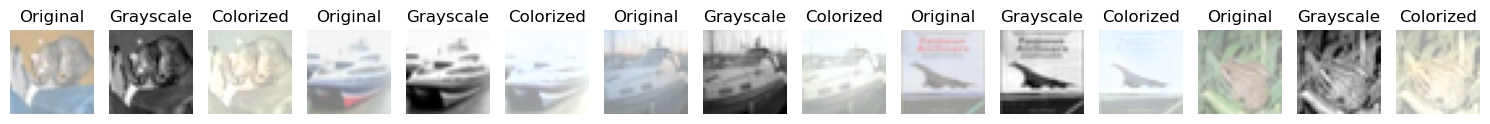

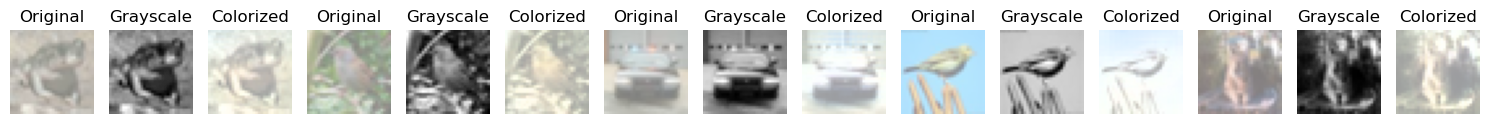

In [ ]:
# Perform inference and visualization with the model using the test dataset
with torch.no_grad():  # Disable gradient calculations for inference (saves memory and computation)
    for i, (images, _) in enumerate(test_loader):  # Iterate through the test DataLoader
        # Convert RGB images to grayscale and move to the device (e.g., GPU or CPU)
        grayscale_input_batch = rgb_to_gray(images).to(device)
        


        # Generate colorized images using the trained model
        predicted_colorized_batch = model(grayscale_input_batch)


        # Move tensors back to the CPU for visualization
        # Grayscale images: Remove the single grayscale channel for visualization
        grayscale_images_cpu = grayscale_input_batch.cpu().squeeze(1)


        # Colorized images: Move to CPU for further processing
        colorized_images_cpu = predicted_colorized_batch.cpu()


        # Original RGB images: Move to CPU for direct visualization
        original_images_cpu = images.cpu()
        

        # Enhance the predicted colorized images using exaggeration 
        colorized_images_cpu = exaggerate_colors(colorized_images_cpu)

        # Visualize the grayscale, colorized, and original images side by side
        visualize_all_three(original_images_cpu, grayscale_images_cpu, colorized_images_cpu)

      
        if i == 1:  # Stop after processing 10 batches
            break


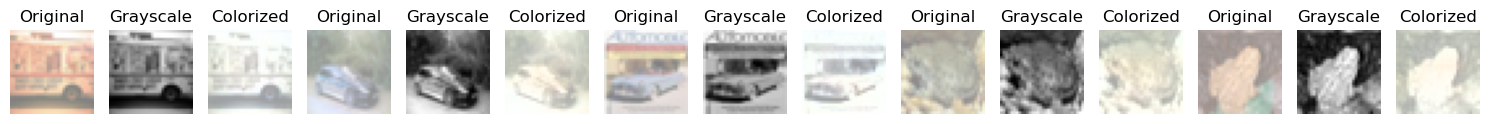

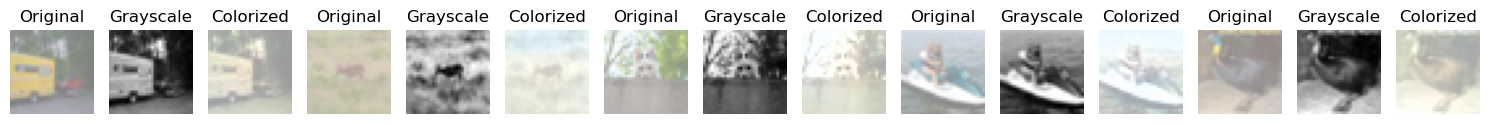

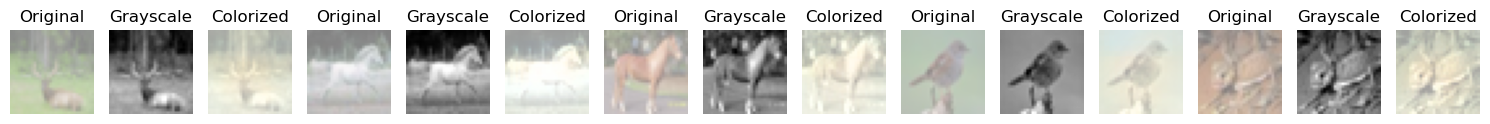

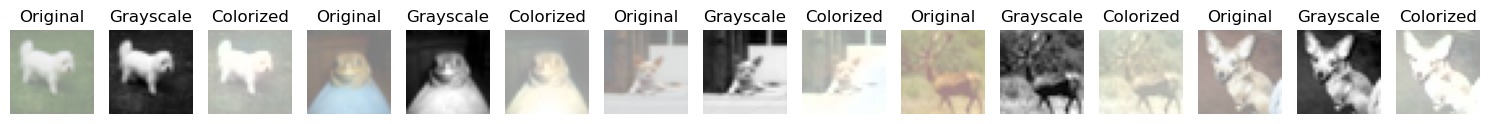

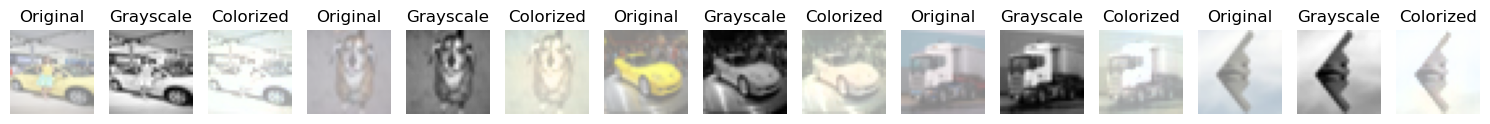

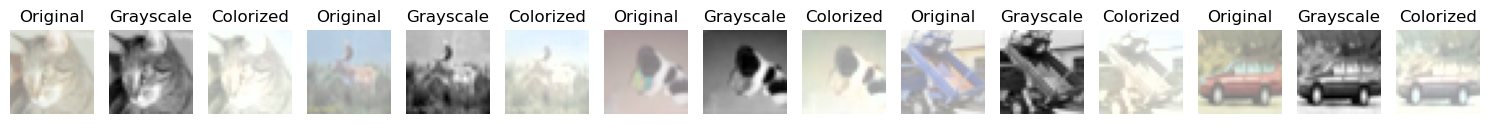

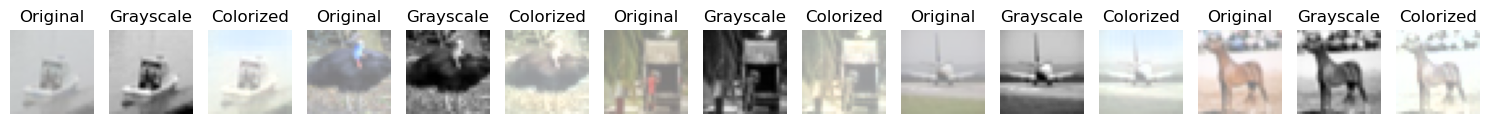

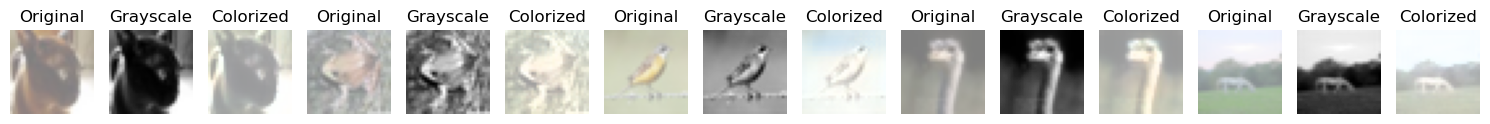

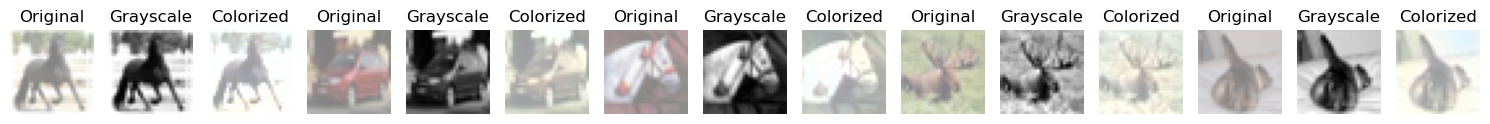

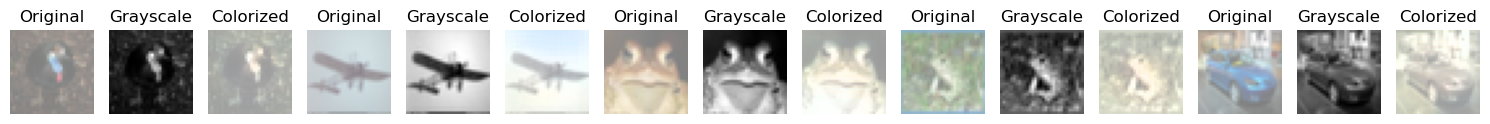

In [10]:
import random

# Get the total number of batches in the test loader
num_batches = len(test_loader)
random_indices = random.sample(range(num_batches), 10)  # Randomly pick 10 different batch indices

with torch.no_grad():
    for i, (images, _) in enumerate(test_loader):
        if i in random_indices:
            grayscale_images = rgb_to_gray(images).to(device)
            colorized_images = model(grayscale_images)

            # Convert the tensors back to CPU for visualization
            grayscale_images_cpu = grayscale_images.cpu().squeeze(1)  # remove the color channel
            colorized_images_cpu = colorized_images.cpu()
            original_images_cpu = images.cpu()

            # Apply your color scaling function
            colorized_images_cpu = exaggerate_colors(colorized_images_cpu)

            # Visualize the grayscale, colorized, and original images
            visualize_all_three(original_images_cpu, grayscale_images_cpu, colorized_images_cpu)


# Model Saving & Loading 
This block handles saving and loading the model's state dictionary, which is crucial for saving the trained model for future use or sharing.

In [12]:
model_path = 'backend\second_trained_model.pth'
torch.save(model.state_dict(), model_path)
model.load_state_dict(torch.load(model_path))
model.eval()  # Set the model to evaluation mode

ColorizationNet(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(4, 4), dilation=(2, 2))
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(4, 4), dilation=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(4, 4), dilation=(2, 2))
  (conv4): Conv2d(128, 3, kernel_size=(5, 5), stride=(1, 1), padding=(4, 4), dilation=(2, 2))
)

# Using Saved Model
This block demonstrates how to use a trained colorization model to colorize a single grayscale image and visualize the results. The process is divided into several steps
it is important this wont look good if you have run the cells above.

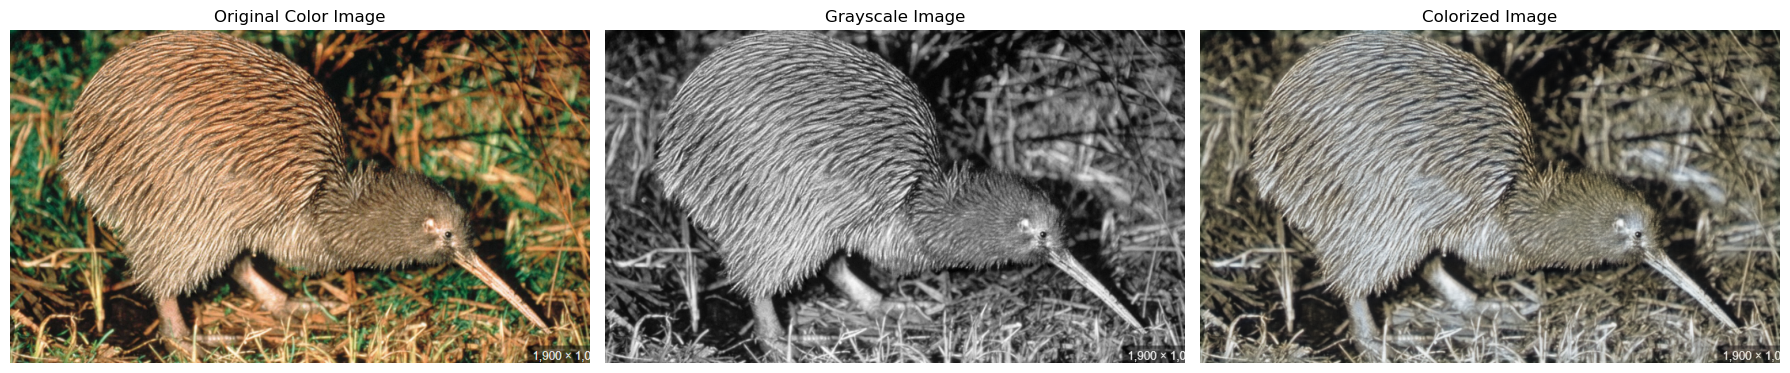

In [22]:
from PIL import Image

# Open the image. (Keep your image in the current directory. In my case, the image was horse.jpg)
img = Image.open("kiwi.png")

# Convert the image to grayscale
gray_img = img.convert("L")

import torchvision.transforms as transforms

# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    # If you need to normalize, uncomment the following line
    # transforms.Normalize(mean=[0.5], std=[0.5])  # Assuming you want to normalize to [-1, 1] range
])
# Apply the transformations
img_tensor = transform(gray_img).unsqueeze(0)  # Add a batch dimension

# Ensure the model is in evaluation mode
model.eval()

# Move the image tensor to the device where your model is (likely 'cuda' if using GPU)
img_tensor = img_tensor.to(device)

# Get the model's output
with torch.no_grad():
    colorized_tensor = model(img_tensor)

# Convert the tensor back to an image
colorized_img = transforms.ToPILImage()(colorized_tensor.squeeze(0).cpu())

# Optionally, save the image
colorized_img.save("image_colorized.jpg")

# Plotting the original, grayscale, and colorized images side-by-side
fig, ax = plt.subplots(1, 3, figsize=(18, 6))  # Create a figure with 1 row and 3 columns

# Display original color image
ax[0].imshow(img)
ax[0].set_title("Original Color Image")
ax[0].axis('off')  # Hide axes

# Display grayscale image
ax[1].imshow(gray_img, cmap='gray')  # Since it's grayscale, use cmap='gray'
ax[1].set_title("Grayscale Image")
ax[1].axis('off')  # Hide axes

# Display colorized image
ax[2].imshow(colorized_img)
ax[2].set_title("Colorized Image")
ax[2].axis('off')  # Hide axes

plt.tight_layout()  # Adjust spacing
plt.show()



# MODEL METRICS DISPLAY 
this cell is just for displaying the model metrics its mainly used for evaluation and testing

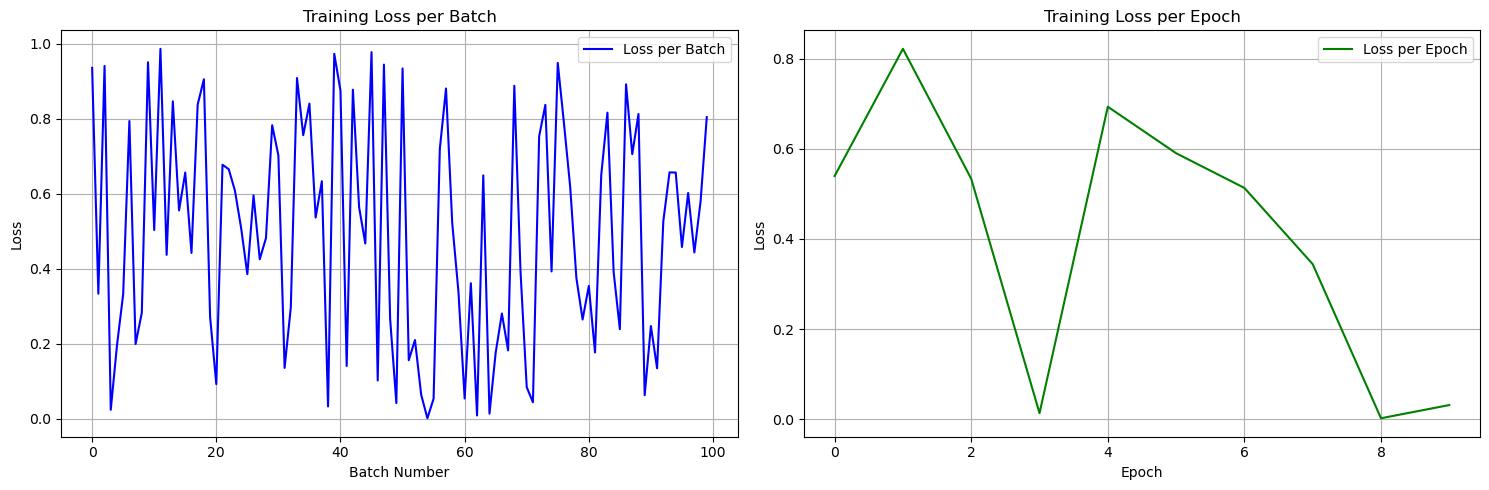

Total Parameters: 318659
Trainable Parameters: 318659
Non-Trainable Parameters: 0


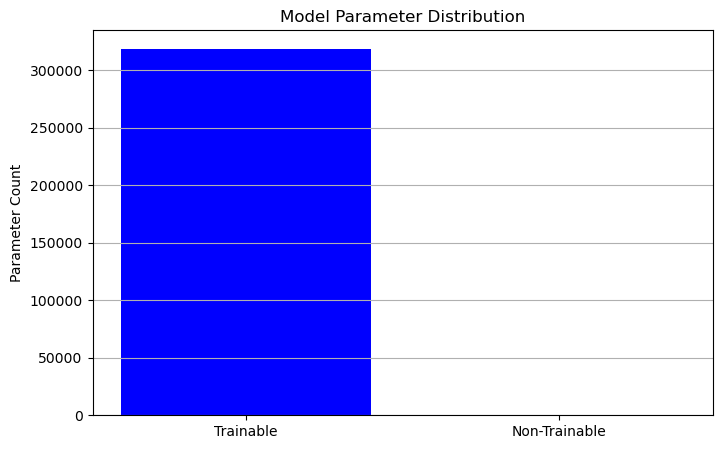

ColorizationNet(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(4, 4), dilation=(2, 2))
  (conv2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(4, 4), dilation=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(4, 4), dilation=(2, 2))
  (conv4): Conv2d(128, 3, kernel_size=(5, 5), stride=(1, 1), padding=(4, 4), dilation=(2, 2))
)


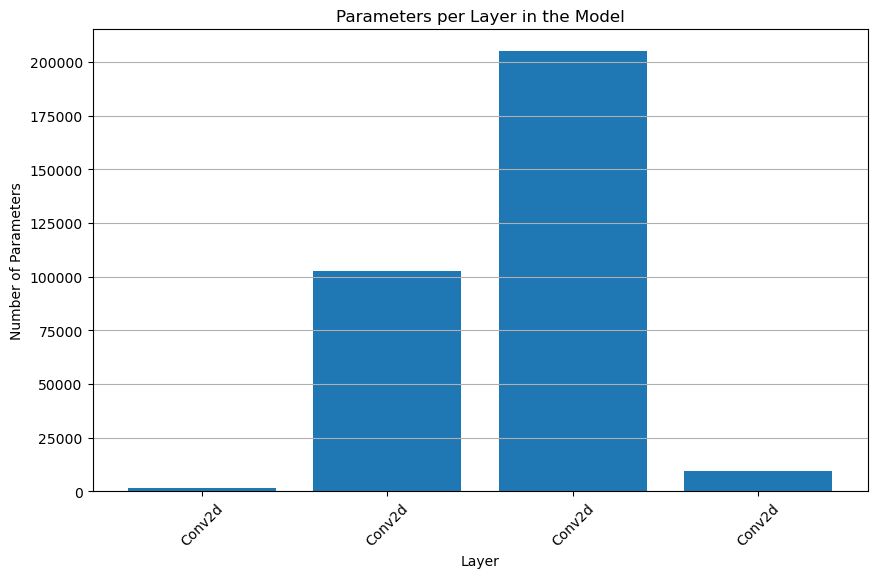

In [21]:


# Function to plot loss per batch and epoch
def plot_training_metrics(batch_losses, epoch_losses):
    """
    Plots the training metrics (loss per batch and loss per epoch).

    Args:
        batch_losses (list): List of batch losses recorded during training.
        epoch_losses (list): List of epoch losses recorded during training.
    """
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plot batch losses
    axs[0].plot(batch_losses, label='Loss per Batch', color='blue')
    axs[0].set_title('Training Loss per Batch')
    axs[0].set_xlabel('Batch Number')
    axs[0].set_ylabel('Loss')
    axs[0].grid(True)
    axs[0].legend()

    # Plot epoch losses
    axs[1].plot(epoch_losses, label='Loss per Epoch', color='green')
    axs[1].set_title('Training Loss per Epoch')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Loss')
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

# Function to calculate and display model parameter information
def display_model_info(model):
    """
    Displays the number of trainable and non-trainable parameters in the model.

    Args:
        model (torch.nn.Module): The PyTorch model to analyze.
    """
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params

    print(f"Total Parameters: {total_params}")
    print(f"Trainable Parameters: {trainable_params}")
    print(f"Non-Trainable Parameters: {non_trainable_params}")

    # Bar chart to visualize parameter distribution
    plt.figure(figsize=(8, 5))
    plt.bar(['Trainable', 'Non-Trainable'], [trainable_params, non_trainable_params], color=['blue', 'orange'])
    plt.title('Model Parameter Distribution')
    plt.ylabel('Parameter Count')
    plt.grid(axis='y')
    plt.show()

# Function to display the model architecture
def visualize_model_architecture(model):
    """
    Displays the model architecture with layer types and parameter counts.

    Args:
        model (torch.nn.Module): The PyTorch model to visualize.
    """
    print(model)
    layers = [layer for layer in model.children()]
    num_params = [sum(p.numel() for p in layer.parameters() if p.requires_grad) for layer in layers]

    # Plot layer parameter distribution
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(layers)), num_params, tick_label=[type(layer).__name__ for layer in layers])
    plt.title('Parameters per Layer in the Model')
    plt.ylabel('Number of Parameters')
    plt.xlabel('Layer')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()

# Example usage with your model and dummy data
batch_losses = [np.random.random() for _ in range(100)]  # Replace with actual batch losses
epoch_losses = [np.random.random() for _ in range(10)]  # Replace with actual epoch losses

# Plot training metrics
plot_training_metrics(batch_losses, epoch_losses)

# Display model parameter information
display_model_info(model)

# Visualize the model architecture
visualize_model_architecture(model)
